In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from glob import glob


import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50
from keras.callbacks import TensorBoard

from functools import partial
from multiprocessing import Pool

import cv2

from PIL import Image

import numpy as np

%matplotlib inline

/Users/royn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('Datas/train.csv')
train_df.head()
train_images = glob("Datas/train/*jpg")
test_images = glob("../input/test/*jpg")

In [3]:
train_df["Image"] = train_df["Image"].map( lambda x : "Datas/train/"+x)
ImageToLabelDict = dict(zip(train_df["Image"], train_df["Id"]))

In [4]:
SIZE = 64
#image are imported with a resizing and a black and white conversion
def ImportImage(filename):
    img = Image.open(filename).convert("LA").resize((SIZE,SIZE))
    return np.array(img)[:,:,0]
train_img = np.array([ImportImage(img) for img in train_images])
x = train_img

In [5]:
class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.la.transform( x.reshape(-1,1)))
    def inverse_tranform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_tranform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform(x)

y = list(map(ImageToLabelDict.get, train_images))
lohe = LabelOneHotEncoder()
y_cat = lohe.fit_transform(y)

In [6]:
def plotImages(images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape((SIZE,SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()

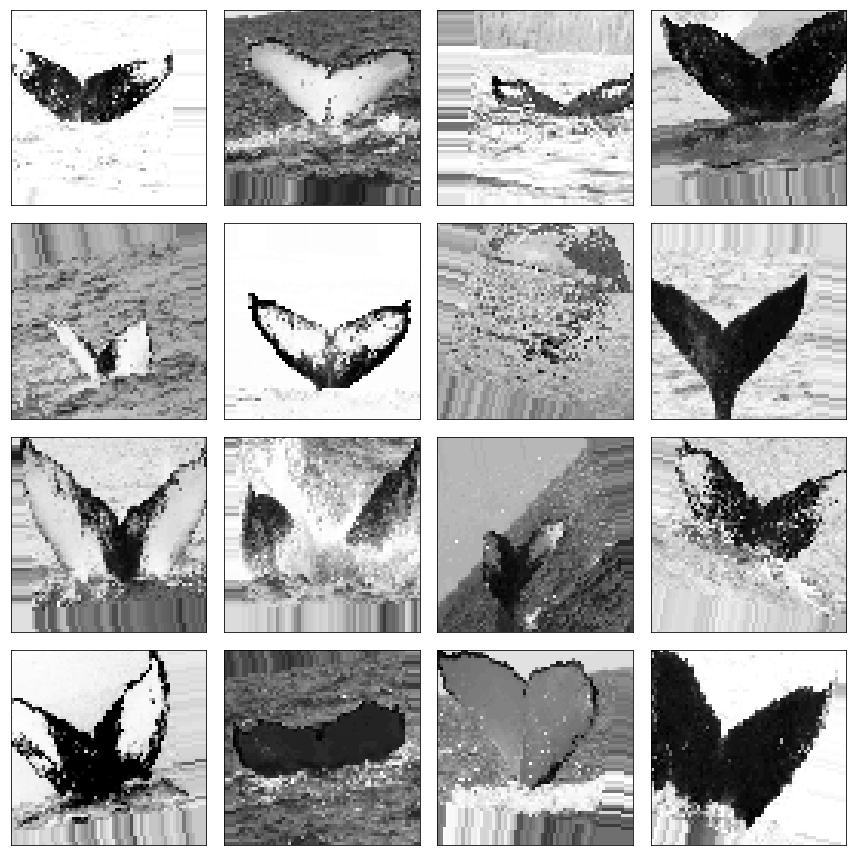

In [7]:
#use of an image generator for preprocessing and data augmentation
x = x.reshape((-1,SIZE,SIZE,1))
input_shape = x[0].shape
x_train = x.astype("float32")
y_train = y_cat

image_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

#training the image preprocessing
image_gen.fit(x_train, augment=True)

#visualization of some images out of the preprocessing
augmented_images, _ = next( image_gen.flow( x_train, y_train.toarray(), batch_size=4*4))
plotImages( augmented_images)

In [8]:
batch_size = 64
num_classes = len(y_cat.toarray()[0])

model1 = Sequential()
model1.add(Conv2D(48, kernel_size=(3, 3),
                 activation='elu',
                 input_shape=input_shape))
model1.add(Conv2D(48, (3, 3), activation='elu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.33))
model1.add(Flatten())
model1.add(Dropout(0.33))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model1.summary()
model1.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=32),
          steps_per_epoch=10,
          epochs=10,
          verbose=1,
          callbacks=[TensorBoard(log_dir='./tmp/log', write_graph=True)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 48)        480       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 48)        20784     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 48)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43200)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 43200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4251)              183647451 
Total para

In [10]:
batch_size = 64
num_classes = len(y_cat.toarray()[0])

model = Sequential()
model.add(Conv2D(48, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(48, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(48, (5, 5), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.33))
model.add(Flatten())
model.add(Dense(36, activation='sigmoid'))
model.add(Dropout(0.33))
model.add(Dense(36, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))

model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model1.summary()
model1.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=32),
          steps_per_epoch=  x_train.shape[0]//batch_size,
          epochs=20,
          verbose=1,
          callbacks=[TensorBoard(log_dir='./tmp/log', write_graph=True)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 48)        480       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 48)        20784     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 48)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 43200)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 43200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4251)              183647451 
Total para

In [10]:
batch_size = 64
num_classes = len(y_cat.toarray()[0])

model = Sequential()

#picking vgg16 as pretrained (base) model https://keras.io/applications/#vgg16
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
for layer in conv_base.layers:
    layer.trainable = False

#maybe unfreeze last layer
conv_base.layers[-2].trainable = True

model.add(conv_base)
model.add(Flatten())
model.add(Dropout(0.33))
model.add(Dense(48, activation='relu')) #64
model.add(Dropout(0.33))
model.add(Dense(48, activation='relu')) #48
model.add(Dropout(0.33))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()
model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
          steps_per_epoch=x_train.shape[0] // epochs,
          epochs=epochs,
          verbose=1,
          callbacks=[TensorBoard(log_dir='./tmp/log', write_graph=True)])

ValueError: The input must have 3 channels; got `input_shape=(64, 64, 1)`

In [ ]:
conv_base = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
for layer in conv_base.layers:
    layer.trainable = False

#maybe unfreeze last layer
conv_base.layers[-2].trainable = True

model.add(conv_base)
model.add(Flatten())
model.add(Dropout(0.33))
model.add(Dense(48, activation='relu')) #64
model.add(Dropout(0.33))
model.add(Dense(48, activation='relu')) #48
model.add(Dropout(0.33))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()
model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
          steps_per_epoch=x_train.shape[0] // epochs,
          epochs=epochs,
          verbose=1,
          )